# COMP9444 Project: Leaf Disease Classification
# ProjectID: 048

## Group: Hello World !
## Members: 
##### Yi Ren(z5567992)    Haoyu Guo(z5568296)   Yi Chen(z5567828)   Dongbin Pu(z5580978)   Yixiao Wang(z5519041)

#### 1. Data analysis

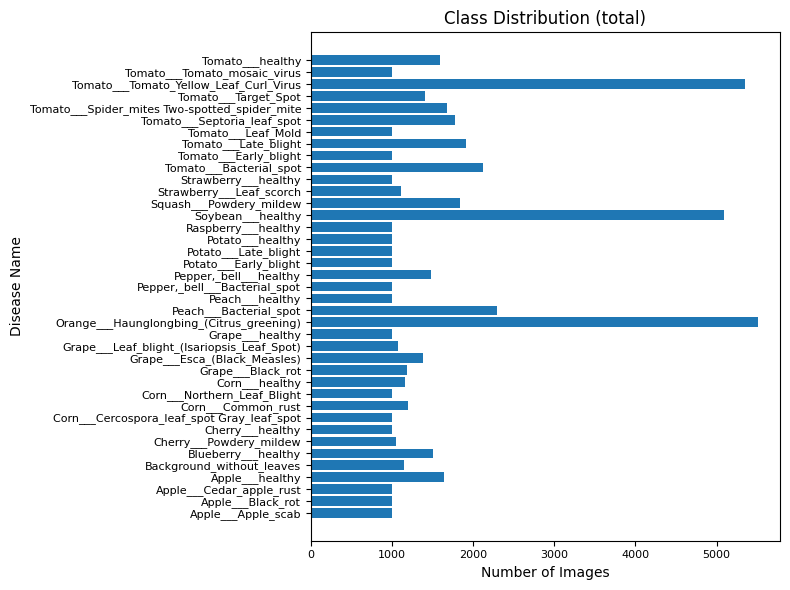

In [ ]:
from torchvision import datasets
import matplotlib.pyplot as plt
from collections import Counter

# Load entire dataset
train_set = datasets.ImageFolder('Plant_leave_diseases_dataset_without_augmentation')

# Count number of images each class
class_counts = Counter(train_set.targets)
class_names = train_set.classes
counts = [class_counts[i] for i in range(len(class_names))]

# Visualize distribution
plt.figure(figsize=(8, 6))
plt.barh(class_names, counts)
plt.xlabel("Number of Images", fontsize=10)
plt.ylabel("Disease Name", fontsize=10)
plt.title("Class Distribution (total)", fontsize=12)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.tight_layout()
plt.show()


#### 2.  Data preprocessing

In [ ]:
import os
import random
import numpy as np
from PIL import Image
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import random_split
import torch

# Set global random seed for reproducibility
def set_seed(seed: int = 9444):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(9444)
generator = torch.Generator().manual_seed(9444)

# Clean up corrupted images from the dataset
def clean_corrupted_images(root: str):
    bad_images = []
    for cls in os.listdir(root):
        cls_path = os.path.join(root, cls)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    try:
                        with Image.open(img_path) as img:
                            img.verify()
                    except Exception:
                        print(f" Corrupted image removed: {img_path}")
                        bad_images.append(img_path)
                        os.remove(img_path)
    print(f"Total corrupted images removed: {len(bad_images)}")

root_dir = 'Plant_leave_diseases_dataset_without_augmentation'
clean_corrupted_images(root_dir)

# Load full dataset
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
full_dataset = datasets.ImageFolder(root=root_dir, transform=base_transform)
class_names = full_dataset.classes

# Randomly split dataset into Train (70%), Val (15%), Test (15%)
total = len(full_dataset)
train_len = int(0.7 * total)
val_len   = int(0.15 * total)
test_len  = total - train_len - val_len

train_set, val_set, test_set = random_split(
    full_dataset, [train_len, val_len, test_len], generator=generator
)

# Define transform for augmentation
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Save images
def save_dataset_images(dataset, indices, class_names, base_dataset, output_dir, use_augment=False):
    os.makedirs(output_dir, exist_ok=True)
    for i, (img_tensor, label) in enumerate(dataset):
        orig_path = base_dataset.samples[indices[i]][0]
        orig_image = Image.open(orig_path).convert("RGB")

        class_name = class_names[label]
        class_dir  = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        file_stem = os.path.splitext(os.path.basename(orig_path))[0]
        save_path = os.path.join(class_dir, f"{file_stem}.png")

        if not use_augment:
            # Save resized original image
            resized = transforms.Resize((224, 224))(orig_image)
            save_image(transforms.ToTensor()(resized), save_path)
        else:
            # Apply deterministic augmentation
            torch.manual_seed(9444 + i)
            aug_img = augmentation_transform(orig_image)
            save_image(aug_img, save_path)

        # Logging progress
        if (i + 1) % 100 == 0 or (i + 1) == len(dataset):
            print(f"[{os.path.basename(output_dir)}] Saved {i + 1}/{len(dataset)} images")

# Save original training images
aug_train_dir = "preprocessed_dataset/augmented_train_pairs"
save_dataset_images(train_set, train_set.indices, class_names, full_dataset, aug_train_dir, use_augment=False)


# Balance classes in the training set to 70% of the largest class using augmentation
def balance_dataset_to_70_percent(train_dir):
    valid_exts = ('.jpg', '.jpeg', '.png')
    class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
    max_count = max(class_counts.values())
    target_count = int(max_count * 0.7)

    print(f"\nMax class count: {max_count}")
    print(f"Target count (70%): {target_count}\n")

    for cls, count in class_counts.items():
        if count < target_count:
            cls_dir = os.path.join(train_dir, cls)
            images = [f for f in os.listdir(cls_dir) if f.lower().endswith(valid_exts)]
            needed = target_count - count
            print(f"Balancing {cls}: {count} → {target_count} (+{needed})")

            for i in range(needed):
                src_img = random.choice(images)
                img_path = os.path.join(cls_dir, src_img)

                try:
                    img = Image.open(img_path).convert("RGB")
                except Exception:
                    print(f"  Skipping corrupted image: {img_path}")
                    os.remove(img_path)
                    continue

                # Augment and save as new file
                torch.manual_seed(9444 + i)
                aug_img = augmentation_transform(img)
                new_name = f"{os.path.splitext(src_img)[0]}_extra{i}.png"
                save_image(aug_img, os.path.join(cls_dir, new_name))

# Apply class balancing to augmented training set
balance_dataset_to_70_percent(aug_train_dir)

# Save validation and test set images
save_dataset_images(val_set, val_set.indices, class_names, full_dataset, "preprocessed_dataset/val_pairs", use_augment=False)
save_dataset_images(test_set, test_set.indices, class_names, full_dataset, "preprocessed_dataset/test_pairs", use_augment=False)

print("\n All images successfully saved.")


Total corrupted images removed: 0
[augmented_train_pairs] Saved 100/43040 images
[augmented_train_pairs] Saved 200/43040 images
[augmented_train_pairs] Saved 300/43040 images
[augmented_train_pairs] Saved 400/43040 images
[augmented_train_pairs] Saved 500/43040 images
[augmented_train_pairs] Saved 600/43040 images
[augmented_train_pairs] Saved 700/43040 images
[augmented_train_pairs] Saved 800/43040 images
[augmented_train_pairs] Saved 900/43040 images
[augmented_train_pairs] Saved 1000/43040 images
[augmented_train_pairs] Saved 1100/43040 images
[augmented_train_pairs] Saved 1200/43040 images
[augmented_train_pairs] Saved 1300/43040 images
[augmented_train_pairs] Saved 1400/43040 images
[augmented_train_pairs] Saved 1500/43040 images
[augmented_train_pairs] Saved 1600/43040 images
[augmented_train_pairs] Saved 1700/43040 images
[augmented_train_pairs] Saved 1800/43040 images
[augmented_train_pairs] Saved 1900/43040 images
[augmented_train_pairs] Saved 2000/43040 images
[augmented_trai

#### 3. Data analysis again after preprocessing

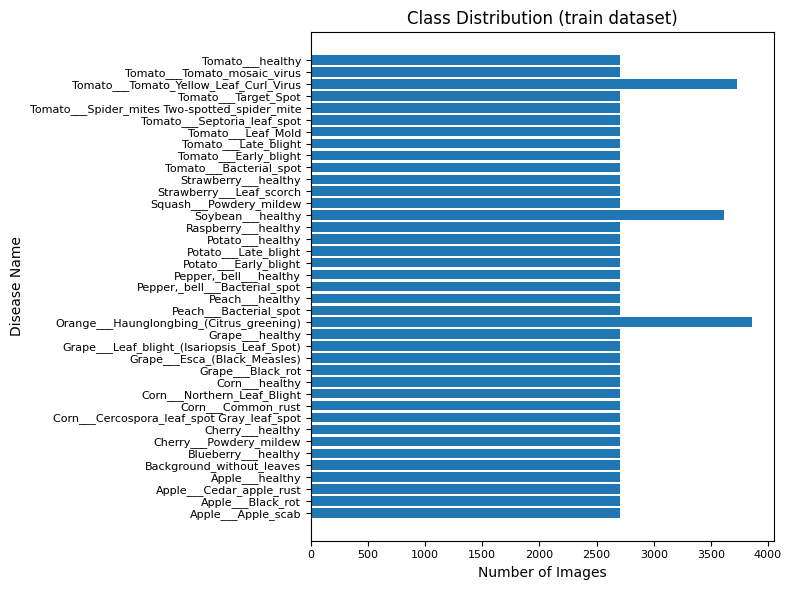

In [ ]:
from torchvision import datasets
import matplotlib.pyplot as plt
from collections import Counter

# Load preprocessed training dataset
train_set = datasets.ImageFolder('preprocessed_dataset/augmented_train_pairs')

# Count number of images per class
class_counts = Counter(train_set.targets)
class_names = train_set.classes
counts = [class_counts[i] for i in range(len(class_names))]

# Visualize class distribution
plt.figure(figsize=(8, 6))
plt.barh(class_names, counts)
plt.xlabel("Number of Images", fontsize=10)
plt.ylabel("Disease Name", fontsize=10)
plt.title("Class Distribution (train dataset)", fontsize=12)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.tight_layout()
plt.show()


#### 4. Baseline: 8-Layer-CNN Grad-CAM

Using device: cuda
Epoch 1,Train Loss: 1.7317, Train Acc: 0.4837
Epoch 1, Validation Loss: 0.6245, Validation Acc: 0.8077
Saved new best model
Epoch 2,Train Loss: 0.6276, Train Acc: 0.7978
Epoch 2, Validation Loss: 0.2872, Validation Acc: 0.9053
Saved new best model
Epoch 3,Train Loss: 0.3675, Train Acc: 0.8770
Epoch 3, Validation Loss: 0.2420, Validation Acc: 0.9228
Saved new best model
Epoch 4,Train Loss: 0.2441, Train Acc: 0.9180
Epoch 4, Validation Loss: 0.1328, Validation Acc: 0.9578
Saved new best model
Epoch 5,Train Loss: 0.1807, Train Acc: 0.9390
Epoch 5, Validation Loss: 0.1299, Validation Acc: 0.9587
Saved new best model
Epoch 6,Train Loss: 0.1382, Train Acc: 0.9532
Epoch 6, Validation Loss: 0.0929, Validation Acc: 0.9729
Saved new best model
Epoch 7,Train Loss: 0.1131, Train Acc: 0.9606
Epoch 7, Validation Loss: 0.0999, Validation Acc: 0.9709
Epoch 8,Train Loss: 0.0926, Train Acc: 0.9686
Epoch 8, Validation Loss: 0.0924, Validation Acc: 0.9712
Epoch 9,Train Loss: 0.0768, Tra

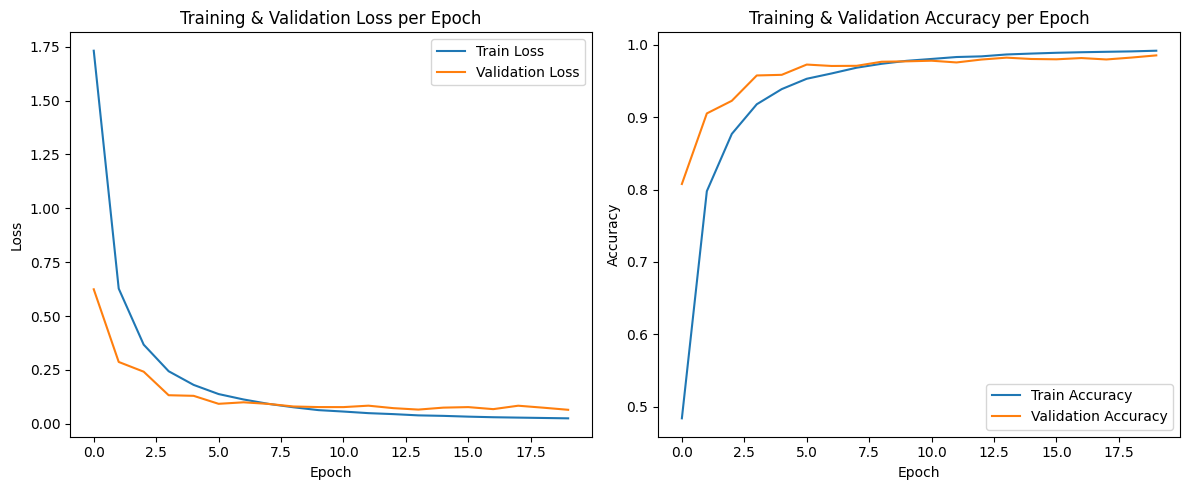

C:\Users\CloudStar\AppData\Local\Temp\ipykernel_17152\1611458920.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('plant_disease_best_m

Test Accuracy: 0.9849
Precision (weighted): 0.9852
Recall (weighted): 0.9849
F1 Score (weighted): 0.9849
Average Inference Time per Image: 0.000027 seconds


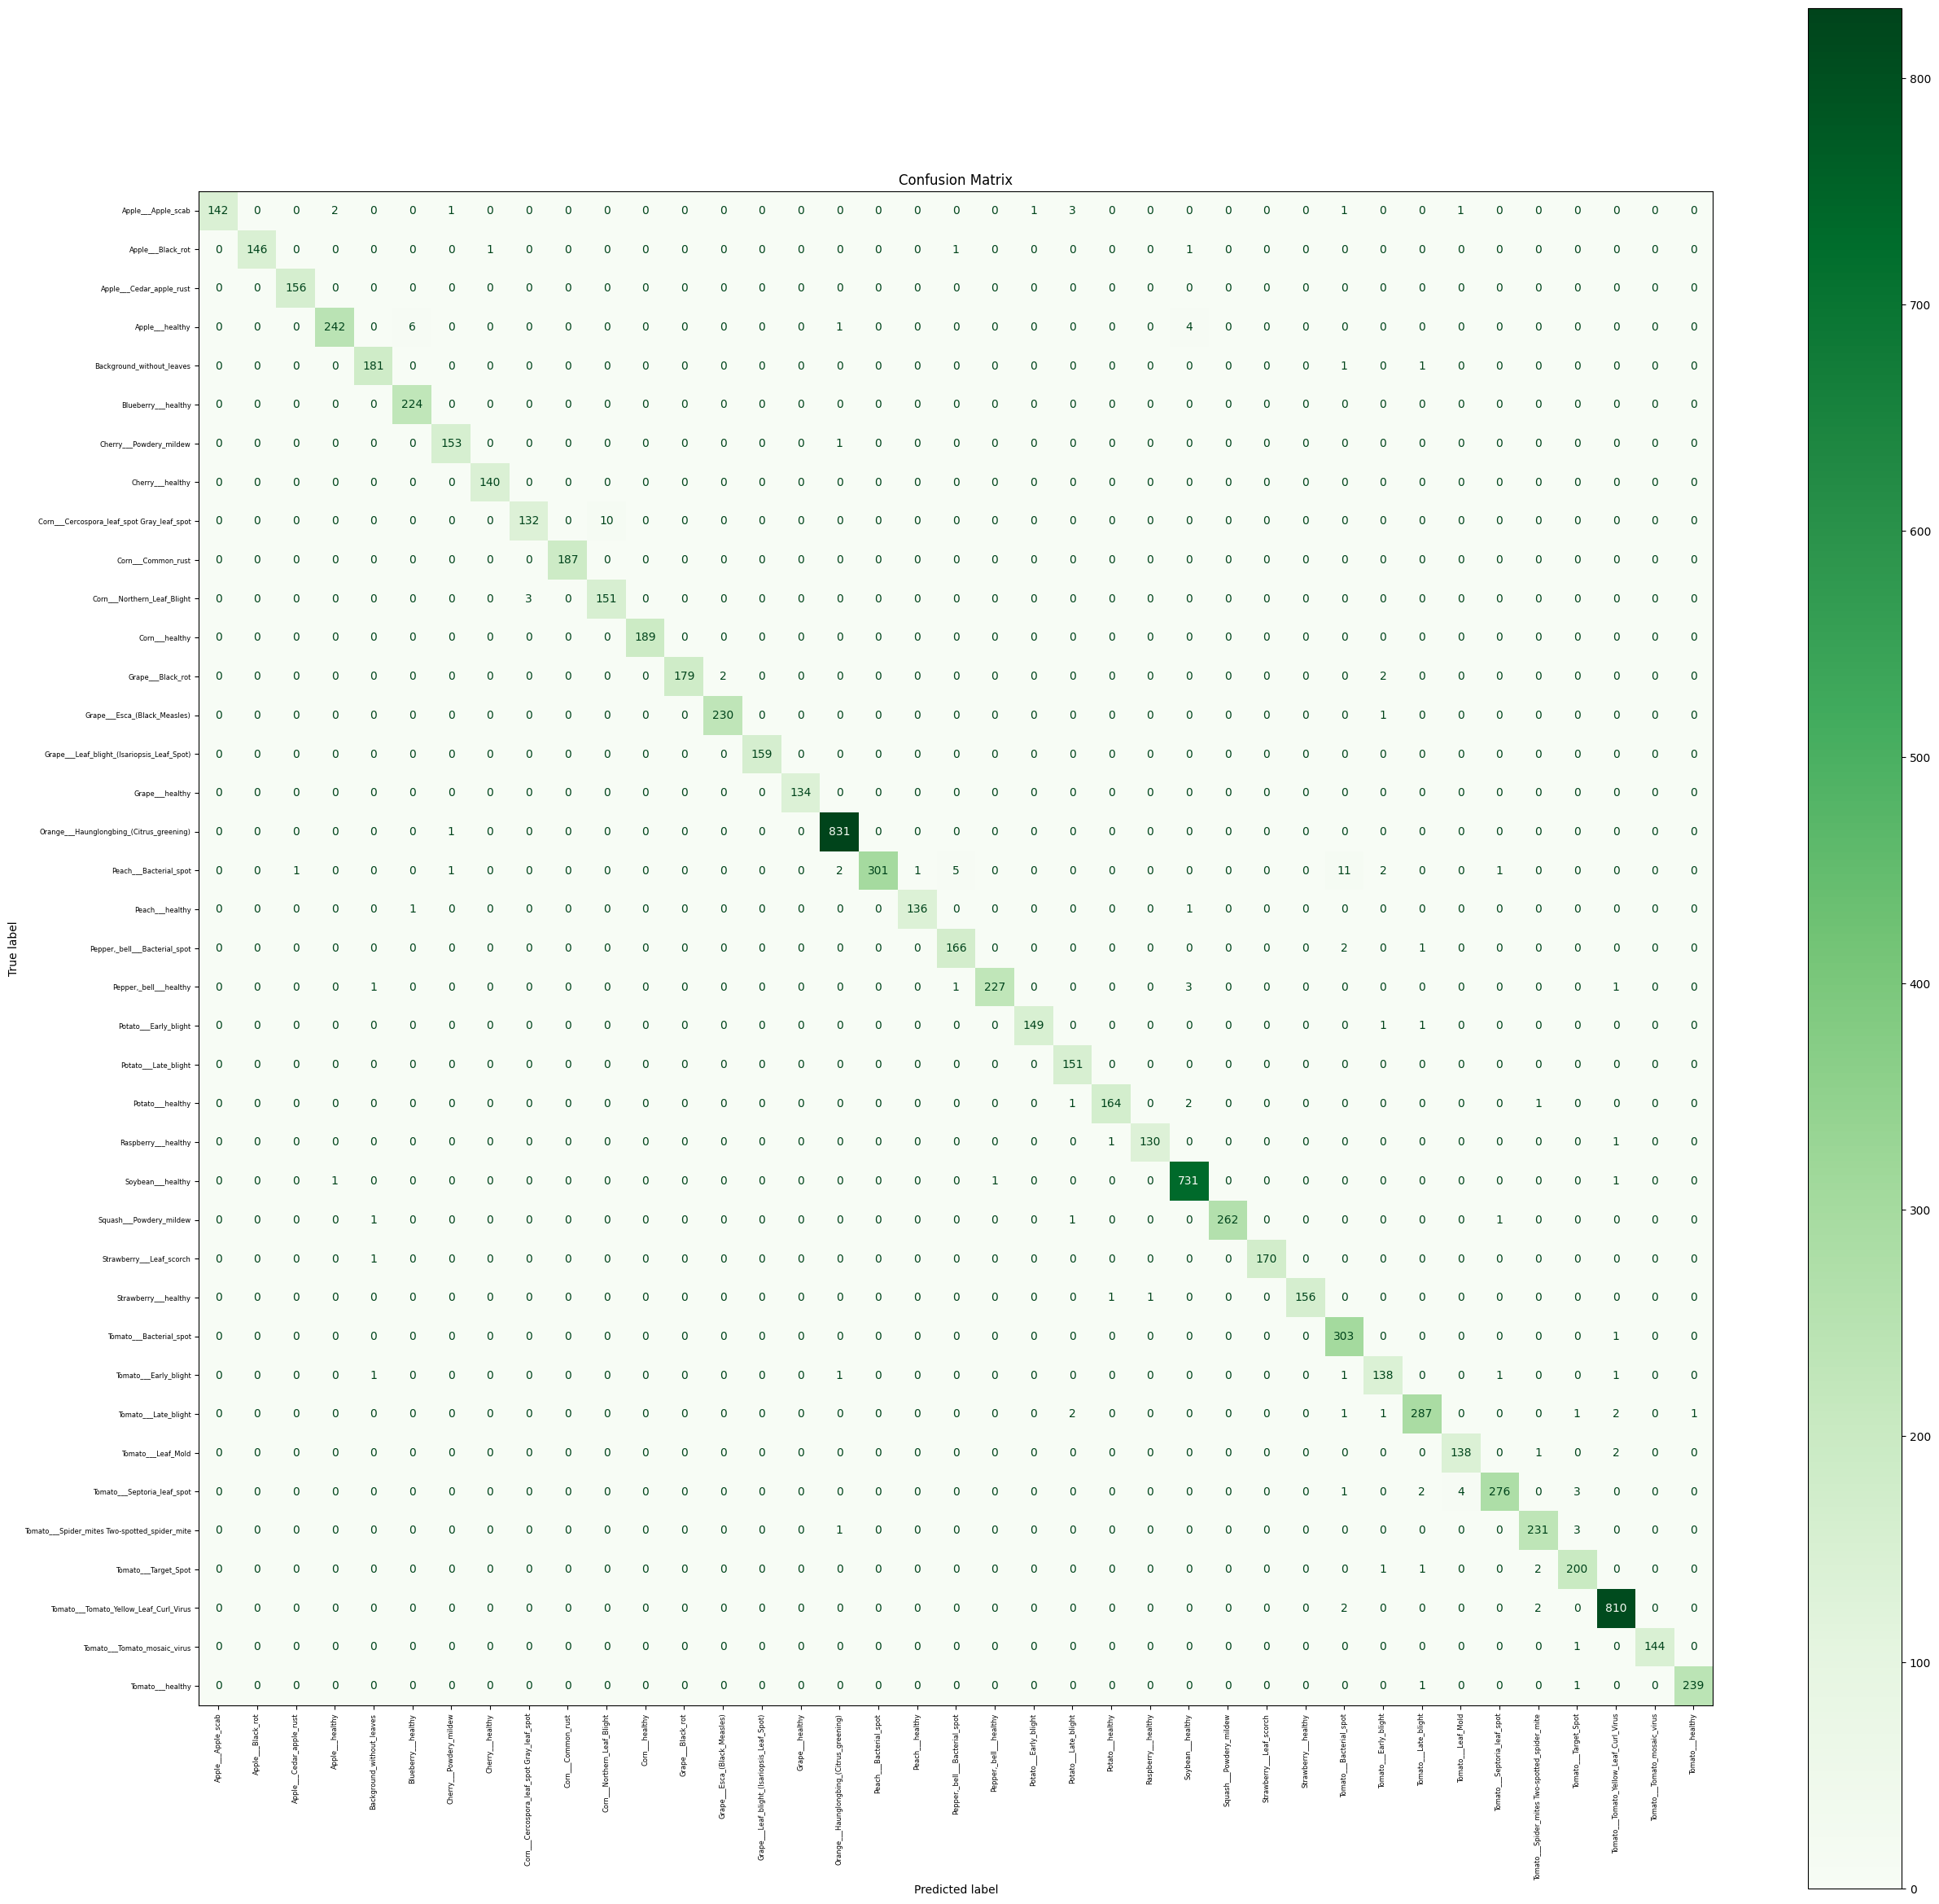


Generating Grad-CAM for test set...
Saved 100/9224 images
Saved 200/9224 images
Saved 300/9224 images
Saved 400/9224 images
Saved 500/9224 images
Saved 600/9224 images
Saved 700/9224 images
Saved 800/9224 images
Saved 900/9224 images
Saved 1000/9224 images
Saved 1100/9224 images
Saved 1200/9224 images
Saved 1300/9224 images
Saved 1400/9224 images
Saved 1500/9224 images
Saved 1600/9224 images
Saved 1700/9224 images
Saved 1800/9224 images
Saved 1900/9224 images
Saved 2000/9224 images
Saved 2100/9224 images
Saved 2200/9224 images
Saved 2300/9224 images
Saved 2400/9224 images
Saved 2500/9224 images
Saved 2600/9224 images
Saved 2700/9224 images
Saved 2800/9224 images
Saved 2900/9224 images
Saved 3000/9224 images
Saved 3100/9224 images
Saved 3200/9224 images
Saved 3300/9224 images
Saved 3400/9224 images
Saved 3500/9224 images
Saved 3600/9224 images
Saved 3700/9224 images
Saved 3800/9224 images
Saved 3900/9224 images
Saved 4000/9224 images
Saved 4100/9224 images
Saved 4200/9224 images
Saved 

In [ ]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import datasets, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Select computing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets from preprocessed folders
batch_size = 32
train_dataset = datasets.ImageFolder("preprocessed_dataset/augmented_train_pairs", transform=transform)
val_dataset   = datasets.ImageFolder("preprocessed_dataset/val_pairs", transform=transform)
test_dataset  = datasets.ImageFolder("preprocessed_dataset/test_pairs", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)

# Define the CNN model
class Plant_Disease_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model and optimizer
model = Plant_Disease_Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
epochs = 20

# Early Stopping settings
best_val_acc = 0
patience = 10  
epochs_no_improve = 0
early_stop = False

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    if early_stop:
        print("Early stopping triggered")
        break

    model.train()
    train_loss = 0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss_epoch = train_loss / len(train_dataset)
    train_losses.append(train_loss_epoch)
    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss_epoch = val_loss / len(val_dataset)
    val_losses.append(val_loss_epoch)
    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1},Train Loss: {train_loss_epoch:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss_epoch:.4f}, Validation Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'plant_disease_best_model.pth')
        print("Saved new best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

# Plot training/validation curves
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig("training_validation_curves.png")
plt.show()

# Evaluation
model.load_state_dict(torch.load('plant_disease_best_model.pth', map_location=device))
model.eval()

all_preds, all_labels = [], []
total_inference_time = 0
total_images = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        start_time = time.time()
        outputs = model(images)
        end_time = time.time()

        total_inference_time += (end_time - start_time)
        total_images += images.size(0)

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

precision = precision_score(all_labels, all_preds, average='weighted') 
print(f"Precision (weighted): {precision:.4f}")

recall = recall_score(all_labels, all_preds, average='weighted')
print(f"Recall (weighted): {recall:.4f}")

f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")

avg_inference_time_per_image = total_inference_time / total_images
print(f"Average Inference Time per Image: {avg_inference_time_per_image:.6f} seconds")

conf_matrix = confusion_matrix(all_labels, all_preds)
conf_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                      display_labels=test_dataset.classes)
fig, ax = plt.subplots(figsize=(30, 30))
conf_display.plot(cmap=plt.cm.Greens, ax=ax, xticks_rotation=90) 
plt.xticks(fontsize=6)  
plt.yticks(fontsize=6)
conf_display.im_.set_clim(0, np.max(conf_matrix))
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png") 
plt.show()

# Grad-CAM visualization for test dataset
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

def generate_gradcam_for_testset(model, dataset, output_dir="CNN_GradCAM"):
    os.makedirs(output_dir, exist_ok=True)
    if hasattr(model, "conv_layers"):
        target_layer = model.conv_layers[-2]
    else:
        raise ValueError("Model must have attribute conv_layers")

    cam = GradCAM(model=model, target_layers=[target_layer])
    for idx, (img_path, label) in enumerate(dataset.samples):
        try:
            class_name = dataset.classes[label]
            class_dir = os.path.join(output_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)

            orig_image = Image.open(img_path).convert("RGB")
            base_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
            img_tensor = base_transform(orig_image)
            input_tensor = img_tensor.unsqueeze(0).to(device)

            rgb_img = denormalize(img_tensor).permute(1, 2, 0).cpu().numpy()
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=[ClassifierOutputTarget(label)])[0]
            grayscale_cam = np.maximum(grayscale_cam, 0)
            grayscale_cam = grayscale_cam / (grayscale_cam.max() + 1e-8)

            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.5)
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            Image.fromarray((rgb_img * 255).astype(np.uint8)).save(
                os.path.join(class_dir, f"original_{base_name}.jpg"))
            Image.fromarray(visualization).save(
                os.path.join(class_dir, f"gradcam_{base_name}.jpg"))

            if (idx + 1) % 100 == 0 or (idx + 1) == len(dataset):
                print(f"Saved {idx + 1}/{len(dataset)} images")

        except Exception as e:
            print(f"Error at index {idx}: {str(e)}")

    print(f"\n Grad-CAM test results saved to {output_dir}")
    del cam
    torch.cuda.empty_cache()

# Grad-CAM on test set
print("\nGenerating Grad-CAM for test set...")
generate_gradcam_for_testset(model, test_dataset)


#### 5. Optimized Model 1: VGG16

Loading dataset ...
Classes: 39
Samples → Train: 108443 | Val: 9222 | Test: 9224
Building VGG16 ...
Training the entire network.
Model ready. Num classes = 39
Start training ...


Epoch 1/20 Train: 100%|██████████| 3389/3389 [50:34<00:00,  1.12it/s]


Epoch 1: Train Loss 0.6317 Acc 0.8093 | Val Loss 0.2944 Acc 0.9160


Epoch 2/20 Train: 100%|██████████| 3389/3389 [50:15<00:00,  1.12it/s]


Epoch 2: Train Loss 0.2243 Acc 0.9328 | Val Loss 0.1211 Acc 0.9637


Epoch 3/20 Train: 100%|██████████| 3389/3389 [50:18<00:00,  1.12it/s]


Epoch 3: Train Loss 0.1715 Acc 0.9492 | Val Loss 0.1383 Acc 0.9609


Epoch 4/20 Train: 100%|██████████| 3389/3389 [50:12<00:00,  1.12it/s]


Epoch 4: Train Loss 0.1465 Acc 0.9576 | Val Loss 0.0936 Acc 0.9723


Epoch 5/20 Train: 100%|██████████| 3389/3389 [50:08<00:00,  1.13it/s]


Epoch 5: Train Loss 0.1293 Acc 0.9627 | Val Loss 0.1115 Acc 0.9705


Epoch 6/20 Train: 100%|██████████| 3389/3389 [50:15<00:00,  1.12it/s]


Epoch 6: Train Loss 0.1275 Acc 0.9640 | Val Loss 0.1075 Acc 0.9684


Epoch 7/20 Train: 100%|██████████| 3389/3389 [50:13<00:00,  1.12it/s]


Epoch 7: Train Loss 0.1103 Acc 0.9685 | Val Loss 0.1332 Acc 0.9674


Epoch 8/20 Train: 100%|██████████| 3389/3389 [50:13<00:00,  1.12it/s]


Epoch 8: Train Loss 0.1172 Acc 0.9677 | Val Loss 0.1046 Acc 0.9747


Epoch 9/20 Train: 100%|██████████| 3389/3389 [50:23<00:00,  1.12it/s]


Epoch 9: Train Loss 0.1147 Acc 0.9685 | Val Loss 0.1070 Acc 0.9729


Epoch 10/20 Train: 100%|██████████| 3389/3389 [50:49<00:00,  1.11it/s]


Epoch 10: Train Loss 0.1096 Acc 0.9694 | Val Loss 0.1144 Acc 0.9704


Epoch 11/20 Train: 100%|██████████| 3389/3389 [1:03:53<00:00,  1.13s/it]


Epoch 11: Train Loss 0.0250 Acc 0.9922 | Val Loss 0.0454 Acc 0.9922


Epoch 12/20 Train: 100%|██████████| 3389/3389 [1:03:46<00:00,  1.13s/it]


Epoch 12: Train Loss 0.0069 Acc 0.9978 | Val Loss 0.0478 Acc 0.9921


Epoch 13/20 Train: 100%|██████████| 3389/3389 [1:03:12<00:00,  1.12s/it]


Epoch 13: Train Loss 0.0047 Acc 0.9986 | Val Loss 0.0565 Acc 0.9914


Epoch 14/20 Train: 100%|██████████| 3389/3389 [1:04:38<00:00,  1.14s/it]


Epoch 14: Train Loss 0.0035 Acc 0.9989 | Val Loss 0.0652 Acc 0.9924


Epoch 15/20 Train: 100%|██████████| 3389/3389 [1:05:28<00:00,  1.16s/it]


Epoch 15: Train Loss 0.0025 Acc 0.9992 | Val Loss 0.0596 Acc 0.9918


Epoch 16/20 Train: 100%|██████████| 3389/3389 [1:05:24<00:00,  1.16s/it]


Epoch 16: Train Loss 0.0027 Acc 0.9992 | Val Loss 0.0674 Acc 0.9925


Epoch 17/20 Train: 100%|██████████| 3389/3389 [1:02:51<00:00,  1.11s/it]


Epoch 17: Train Loss 0.0027 Acc 0.9993 | Val Loss 0.0680 Acc 0.9923


Epoch 18/20 Train: 100%|██████████| 3389/3389 [1:01:07<00:00,  1.08s/it]


Epoch 18: Train Loss 0.0024 Acc 0.9994 | Val Loss 0.0664 Acc 0.9913


Epoch 19/20 Train: 100%|██████████| 3389/3389 [1:04:09<00:00,  1.14s/it]


Epoch 19: Train Loss 0.0018 Acc 0.9995 | Val Loss 0.0748 Acc 0.9915


Epoch 20/20 Train: 100%|██████████| 3389/3389 [1:04:28<00:00,  1.14s/it]


Epoch 20: Train Loss 0.0027 Acc 0.9994 | Val Loss 0.0725 Acc 0.9921
Early stopping.


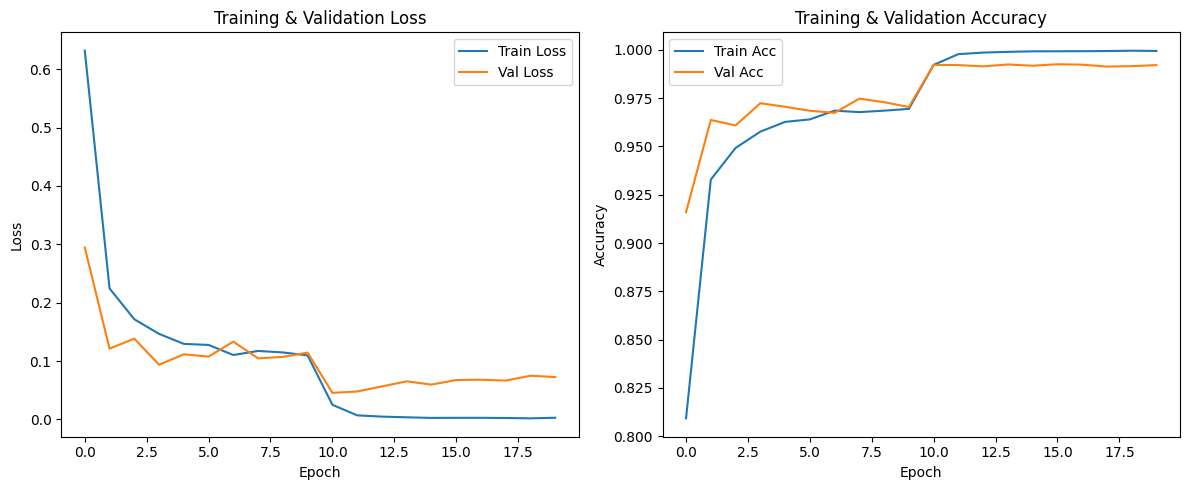

Curves saved to: outputs/plots/training_validation_curves.png
Testing on the held-out test set ...


C:\Users\CloudStar\AppData\Local\Temp\ipykernel_8480\2553433676.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.output_dir /

Test Acc: 0.9900 Precision: 0.9901 Recall: 0.9900 F1: 0.9900


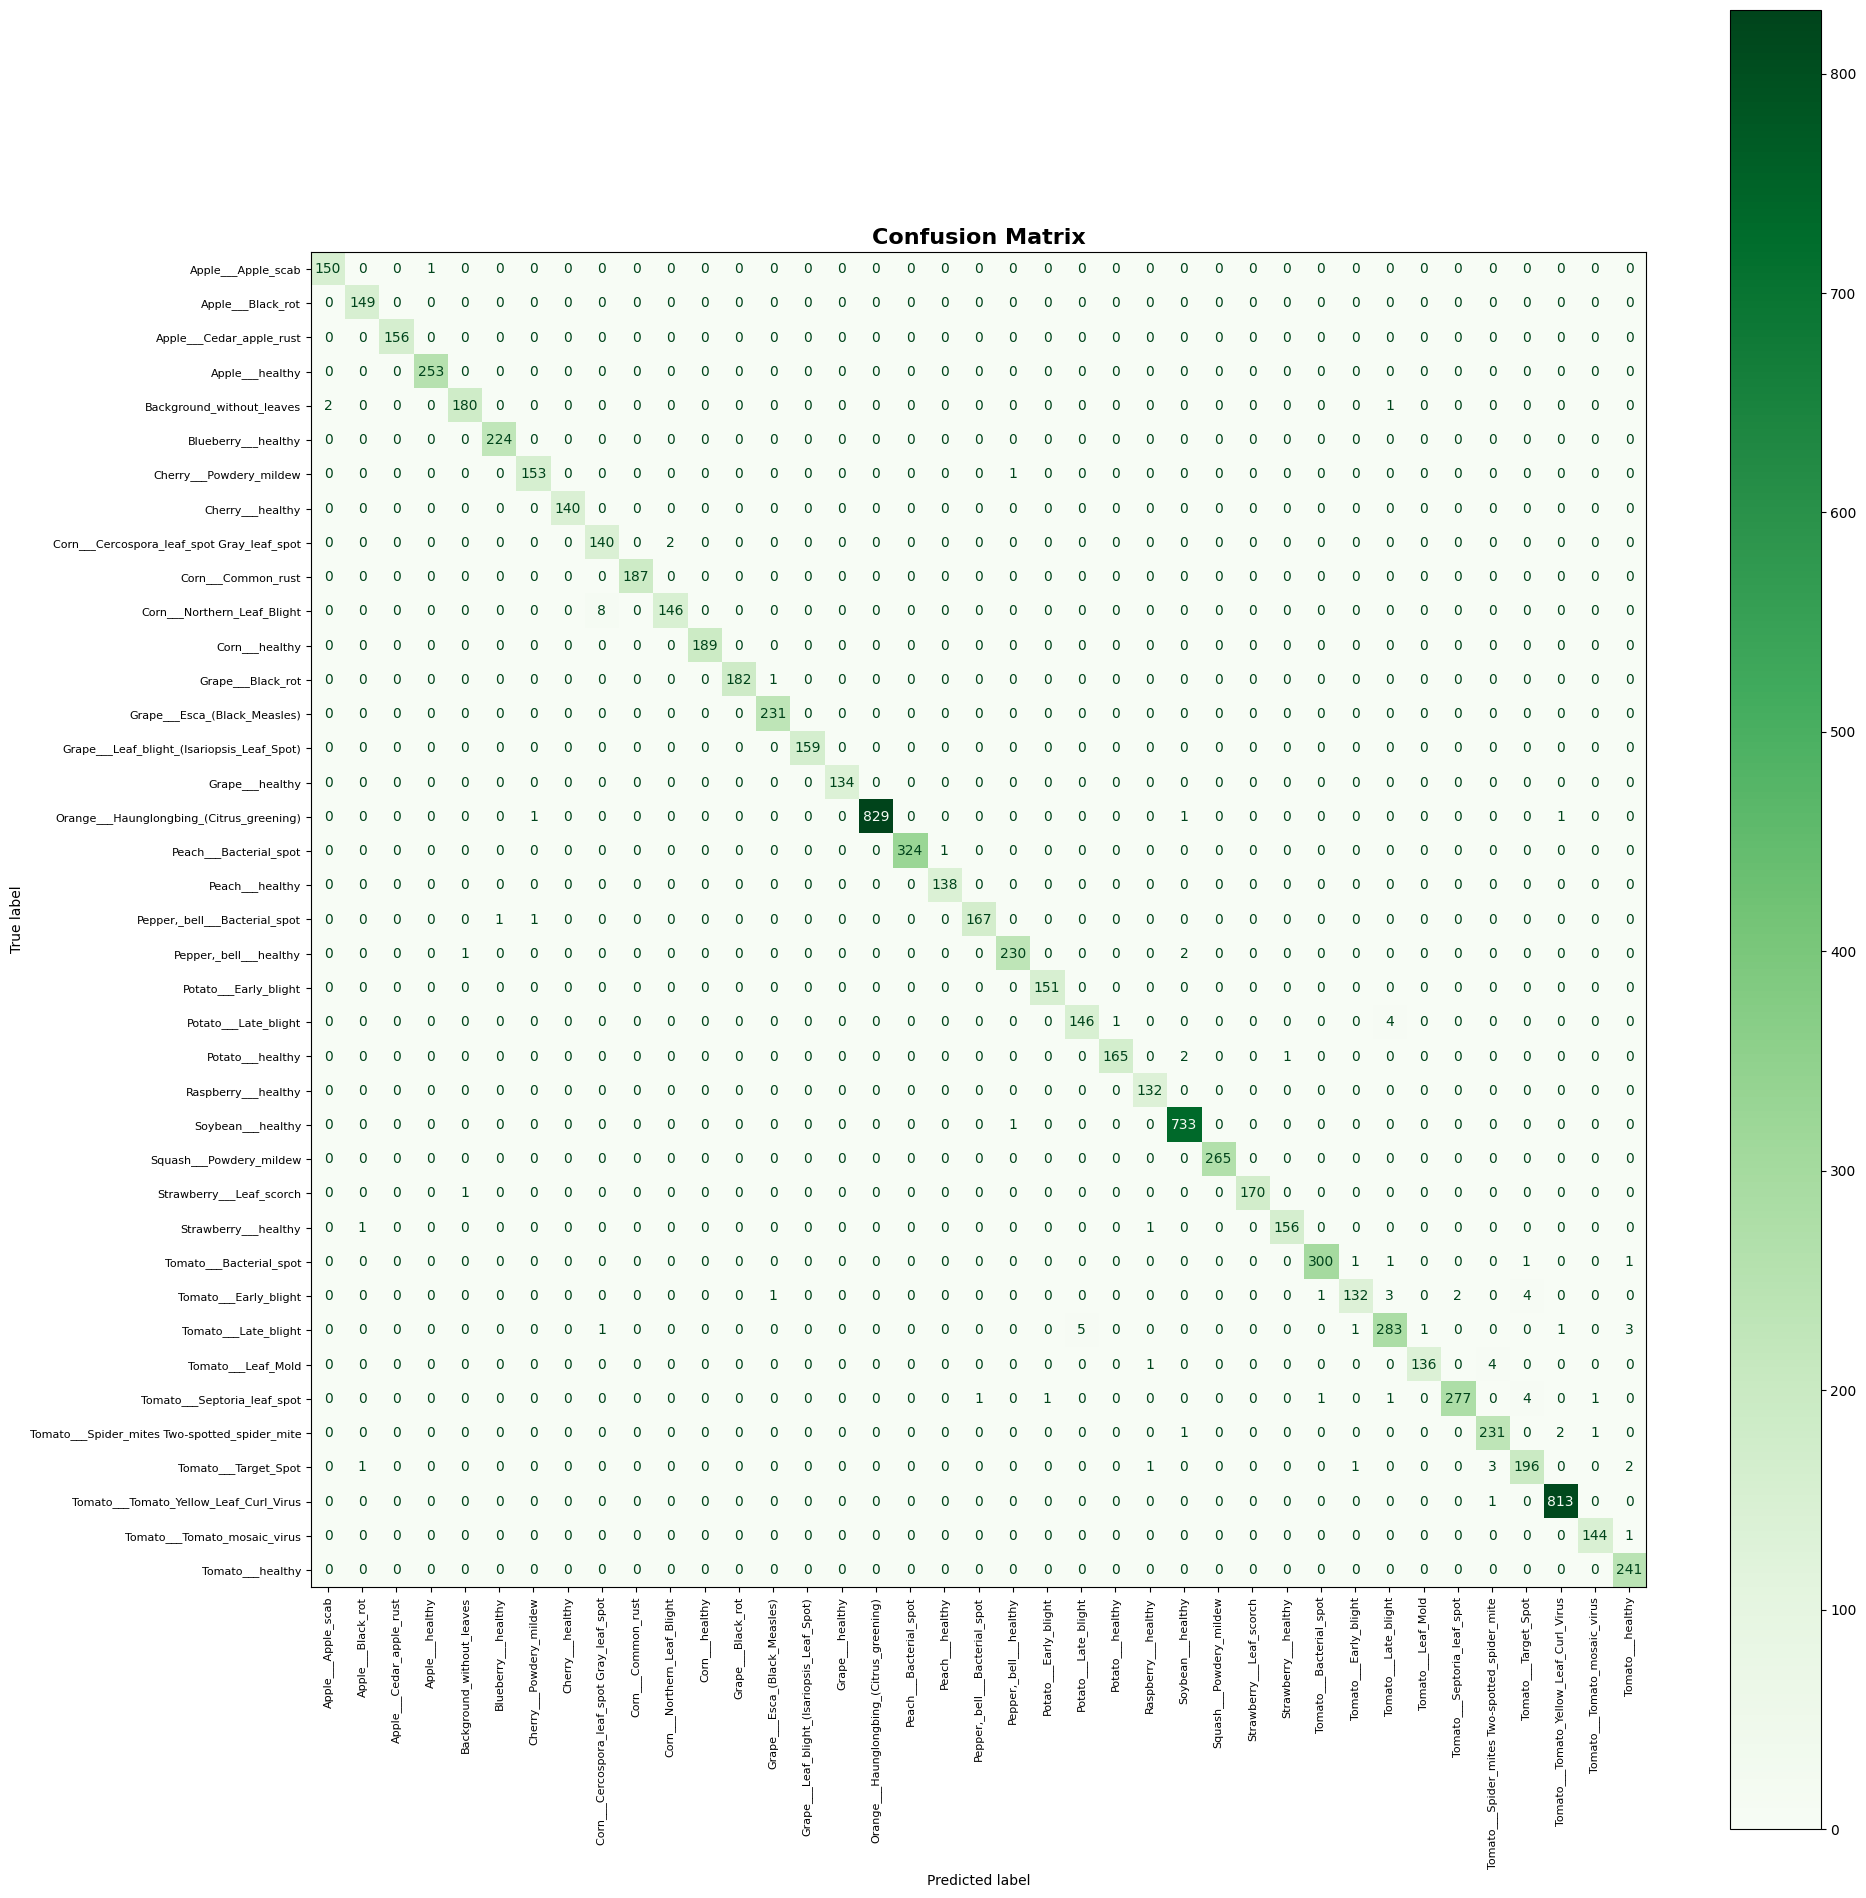

Confusion matrix saved to: outputs/plots/confusion_matrix.png
Generating Grad-CAM ...


C:\Users\CloudStar\AppData\Local\Temp\ipykernel_8480\2553433676.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.output_dir /

Grad-CAM results saved.
All artifacts stored under: outputs


In [ ]:
#!/usr/bin/env python3

import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image

DATA_ROOT = "preprocessed_dataset"

class LeafDiseaseClassifier:
    def __init__(self, args):
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.set_seed(args.seed)

        # Output dirs
        self.output_dir = Path('outputs')
        self.output_dir.mkdir(exist_ok=True)
        (self.output_dir / 'models').mkdir(exist_ok=True)
        (self.output_dir / 'plots').mkdir(exist_ok=True)
    
    # Set the seed for reproducibility
    def set_seed(self, seed=42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def prepare_data(self):
        # Load the dataset
        print("Loading dataset ...")
        base_tf = transforms.Compose([
            transforms.Resize((self.args.img_size, self.args.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.train_set = datasets.ImageFolder(os.path.join(DATA_ROOT, 'augmented_train_pairs'), transform=base_tf)
        self.val_set   = datasets.ImageFolder(os.path.join(DATA_ROOT, 'val_pairs'), transform=base_tf)
        self.test_set  = datasets.ImageFolder(os.path.join(DATA_ROOT, 'test_pairs'), transform=base_tf)

        self.dataset = self.train_set 
        print(f"Classes: {len(self.dataset.classes)}")
        print(f"Samples → Train: {len(self.train_set)} | Val: {len(self.val_set)} | Test: {len(self.test_set)}")

        self.train_loader = DataLoader(self.train_set, batch_size=self.args.batch_size, shuffle=True,  num_workers=2)
        self.val_loader   = DataLoader(self.val_set,   batch_size=self.args.batch_size, shuffle=False, num_workers=2)
        self.test_loader  = DataLoader(self.test_set,  batch_size=self.args.batch_size, shuffle=False, num_workers=2)

    def build_model(self):
        print("Building VGG16 ...")
        self.model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        num_classes = len(self.dataset.classes)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        # Freeze the backbone if specified
        if self.args.freeze_backbone:
            print("Freezing backbone parameters (training only the final FC).")
            for name, param in self.model.named_parameters():
                if not name.startswith('classifier.6'):
                    param.requires_grad = False
        else:
            print("Training the entire network.")

        self.model = self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.args.lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)
        print(f"Model ready. Num classes = {num_classes}")

    def train(self):
        # Train the model
        print("Start training ...")
        best_val_acc = 0.0
        patience_counter = 0


        train_losses, val_losses = [], []
        train_accs,  val_accs  = [], []

        for epoch in range(self.args.epochs):
            self.model.train()
            running_loss, correct, total = 0, 0, 0
            for imgs, lbls in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.args.epochs} Train"):
                imgs, lbls = imgs.to(self.device), lbls.to(self.device)
                self.optimizer.zero_grad()
                out = self.model(imgs)
                loss = self.criterion(out, lbls)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * imgs.size(0)
                pred = out.argmax(1)
                correct += (pred == lbls).sum().item()
                total += lbls.size(0)

            train_loss = running_loss / total
            train_acc  = correct / total
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validation
            self.model.eval()
            val_loss_sum, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for imgs, lbls in self.val_loader:
                    imgs, lbls = imgs.to(self.device), lbls.to(self.device)
                    out = self.model(imgs)
                    loss = self.criterion(out, lbls)
                    val_loss_sum += loss.item() * imgs.size(0)
                    pred = out.argmax(1)
                    val_correct += (pred == lbls).sum().item()
                    val_total += lbls.size(0)

            # Calculate the validation loss and accuracy
            val_loss = val_loss_sum / val_total
            val_acc  = val_correct / val_total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            self.scheduler.step()
            print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

            # Save the best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save(self.model.state_dict(), self.output_dir / 'models' / 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= self.args.patience:
                    print("Early stopping.")
                    break

        self.plot_curves(train_losses, val_losses, train_accs, val_accs)

    def plot_curves(self, train_losses, val_losses, train_accs, val_accs):
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training & Validation Loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training & Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(self.output_dir / 'plots' / 'training_validation_curves.png')
        plt.show()
        plt.close()
        print("Curves saved to: outputs/plots/training_validation_curves.png")

    # Test the model on the test set 
    def test(self):
        print("Testing on the held-out test set ...")
        # Load best weights
        self.model.load_state_dict(torch.load(self.output_dir / 'models' / 'best_model.pth', map_location=self.device))
        self.model.eval()

        y_true, y_pred = [], []
        with torch.no_grad():
            for imgs, lbls in self.test_loader:
                imgs, lbls = imgs.to(self.device), lbls.to(self.device)
                out = self.model(imgs)
                pred = out.argmax(1)
                y_true.extend(lbls.cpu().numpy())
                y_pred.extend(pred.cpu().numpy())


        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec  = recall_score(y_true, y_pred, average='weighted',  zero_division=0)
        f1   = f1_score(y_true, y_pred,    average='weighted',  zero_division=0)
        print(f"Test Acc: {acc:.4f} Precision: {prec:.4f} Recall: {rec:.4f} F1: {f1:.4f}")

    
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=self.dataset.classes)
        fig, ax = plt.subplots(figsize=(20, 20))
        disp.plot(ax=ax, cmap='Greens', xticks_rotation=90)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(self.output_dir / 'plots' / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print("Confusion matrix saved to: outputs/plots/confusion_matrix.png")

    # Add gradcam to the test set
    def gradcam(self):
        print("Generating Grad-CAM ...")
       
        self.model.load_state_dict(torch.load(self.output_dir / 'models' / 'best_model.pth', map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

        cam = GradCAM(model=self.model, target_layers=[self.model.features[-1]])

        # Generate the gradcam for the test set
        for idx, (img_path, label) in enumerate(self.test_set.samples):
            try:
                orig_image = Image.open(img_path).convert("RGB")
                base_transform = transforms.Compose([
                    transforms.Resize((self.args.img_size, self.args.img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
                img_tensor = base_transform(orig_image).unsqueeze(0).to(self.device)
                
                rgb_img = img_tensor.squeeze().detach().cpu()
                for t, m, s in zip(rgb_img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
                    t.mul_(s).add_(m)
                rgb_img = torch.clamp(rgb_img, 0, 1).permute(1, 2, 0).numpy()

                grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(label)])[0]
                visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

                class_dir = Path("outputs/gradcam") / self.test_set.classes[label]
                class_dir.mkdir(parents=True, exist_ok=True)
                fname = Path(img_path).stem
                Image.fromarray(visualization).save(class_dir / f"gradcam_{fname}.jpg")
            except Exception as e:
                print(f"Error at index {idx}: {e}")

        print("Grad-CAM results saved.")

    def run(self):
        self.prepare_data()
        self.build_model()
        self.train()
        self.test()
        self.gradcam()
        print(f"All artifacts stored under: {self.output_dir}")

class Args:
    def __init__(self):
        # Define the arguments
        self.data_dir = DATA_ROOT
        self.epochs = 20
        self.batch_size = 32
        self.lr = 3e-4       
        self.patience = 4    
        self.img_size = 224
        self.seed = 9444
        self.freeze_backbone = False

if __name__ == '__main__':
    args = Args()
    classifier = LeafDiseaseClassifier(args)
    classifier.run()


#### 6. Optimized Model 2: ResNet50

Loading pre-split dataset ...
Classes: 39
Samples → Train: 108443 | Val: 9222 | Test: 9224
Building ResNet-50 ...
Training the entire network.
Model ready. Num classes = 39
Start training ...


Epoch 1/20 Train: 100%|██████████| 3389/3389 [08:04<00:00,  7.00it/s]


Epoch 1: Train Loss 0.1789 Acc 0.9460 | Val Loss 0.0597 Acc 0.9821


Epoch 2/20 Train: 100%|██████████| 3389/3389 [08:15<00:00,  6.85it/s]


Epoch 2: Train Loss 0.0697 Acc 0.9778 | Val Loss 0.0481 Acc 0.9854


Epoch 3/20 Train: 100%|██████████| 3389/3389 [08:17<00:00,  6.81it/s]


Epoch 3: Train Loss 0.0490 Acc 0.9841 | Val Loss 0.0389 Acc 0.9890


Epoch 4/20 Train: 100%|██████████| 3389/3389 [08:17<00:00,  6.81it/s]


Epoch 4: Train Loss 0.0408 Acc 0.9865 | Val Loss 0.0553 Acc 0.9855


Epoch 5/20 Train: 100%|██████████| 3389/3389 [08:17<00:00,  6.81it/s]


Epoch 5: Train Loss 0.0310 Acc 0.9900 | Val Loss 0.0279 Acc 0.9922


Epoch 6/20 Train: 100%|██████████| 3389/3389 [08:18<00:00,  6.80it/s]


Epoch 6: Train Loss 0.0274 Acc 0.9908 | Val Loss 0.0356 Acc 0.9907


Epoch 7/20 Train: 100%|██████████| 3389/3389 [08:18<00:00,  6.79it/s]


Epoch 7: Train Loss 0.0242 Acc 0.9920 | Val Loss 0.0289 Acc 0.9921


Epoch 8/20 Train: 100%|██████████| 3389/3389 [08:16<00:00,  6.82it/s]


Epoch 8: Train Loss 0.0204 Acc 0.9935 | Val Loss 0.0336 Acc 0.9938


Epoch 9/20 Train: 100%|██████████| 3389/3389 [08:17<00:00,  6.82it/s]


Epoch 9: Train Loss 0.0192 Acc 0.9937 | Val Loss 0.0352 Acc 0.9930


Epoch 10/20 Train: 100%|██████████| 3389/3389 [08:18<00:00,  6.80it/s]


Epoch 10: Train Loss 0.0184 Acc 0.9938 | Val Loss 0.0322 Acc 0.9932


Epoch 11/20 Train: 100%|██████████| 3389/3389 [08:19<00:00,  6.79it/s]


Epoch 11: Train Loss 0.0033 Acc 0.9989 | Val Loss 0.0184 Acc 0.9973


Epoch 12/20 Train: 100%|██████████| 3389/3389 [08:16<00:00,  6.83it/s]


Epoch 12: Train Loss 0.0010 Acc 0.9998 | Val Loss 0.0161 Acc 0.9977


Epoch 13/20 Train: 100%|██████████| 3389/3389 [08:18<00:00,  6.80it/s]


Epoch 13: Train Loss 0.0006 Acc 0.9999 | Val Loss 0.0167 Acc 0.9974


Epoch 14/20 Train: 100%|██████████| 3389/3389 [08:18<00:00,  6.79it/s]


Epoch 14: Train Loss 0.0005 Acc 0.9999 | Val Loss 0.0171 Acc 0.9974


Epoch 15/20 Train: 100%|██████████| 3389/3389 [08:19<00:00,  6.79it/s]


Epoch 15: Train Loss 0.0004 Acc 0.9999 | Val Loss 0.0160 Acc 0.9973


Epoch 16/20 Train: 100%|██████████| 3389/3389 [08:17<00:00,  6.81it/s]


Epoch 16: Train Loss 0.0003 Acc 0.9999 | Val Loss 0.0170 Acc 0.9978


Epoch 17/20 Train: 100%|██████████| 3389/3389 [08:18<00:00,  6.80it/s]


Epoch 17: Train Loss 0.0004 Acc 0.9999 | Val Loss 0.0173 Acc 0.9976


Epoch 18/20 Train: 100%|██████████| 3389/3389 [08:17<00:00,  6.81it/s]


Epoch 18: Train Loss 0.0003 Acc 0.9999 | Val Loss 0.0155 Acc 0.9976


Epoch 19/20 Train: 100%|██████████| 3389/3389 [08:44<00:00,  6.46it/s]


Epoch 19: Train Loss 0.0002 Acc 0.9999 | Val Loss 0.0169 Acc 0.9976


Epoch 20/20 Train: 100%|██████████| 3389/3389 [08:34<00:00,  6.59it/s]


Epoch 20: Train Loss 0.0002 Acc 1.0000 | Val Loss 0.0159 Acc 0.9978


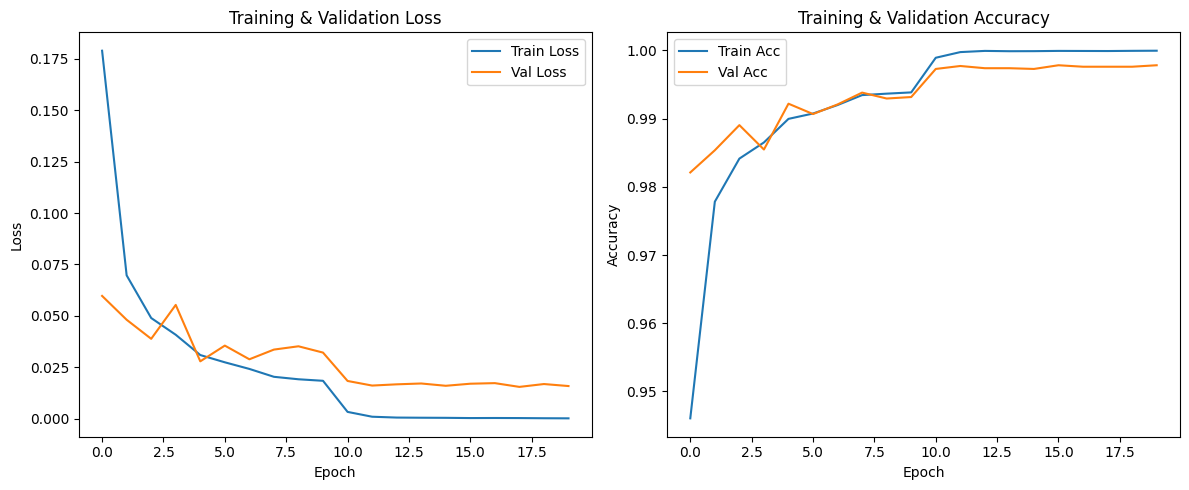

Curves saved to: outputs/plots/training_validation_curves.png
Testing on the held-out test set ...


C:\Users\CloudStar\AppData\Local\Temp\ipykernel_12960\3310186915.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.output_dir 

Test Acc: 0.9971 Precision: 0.9971 Recall: 0.9971 F1: 0.9971


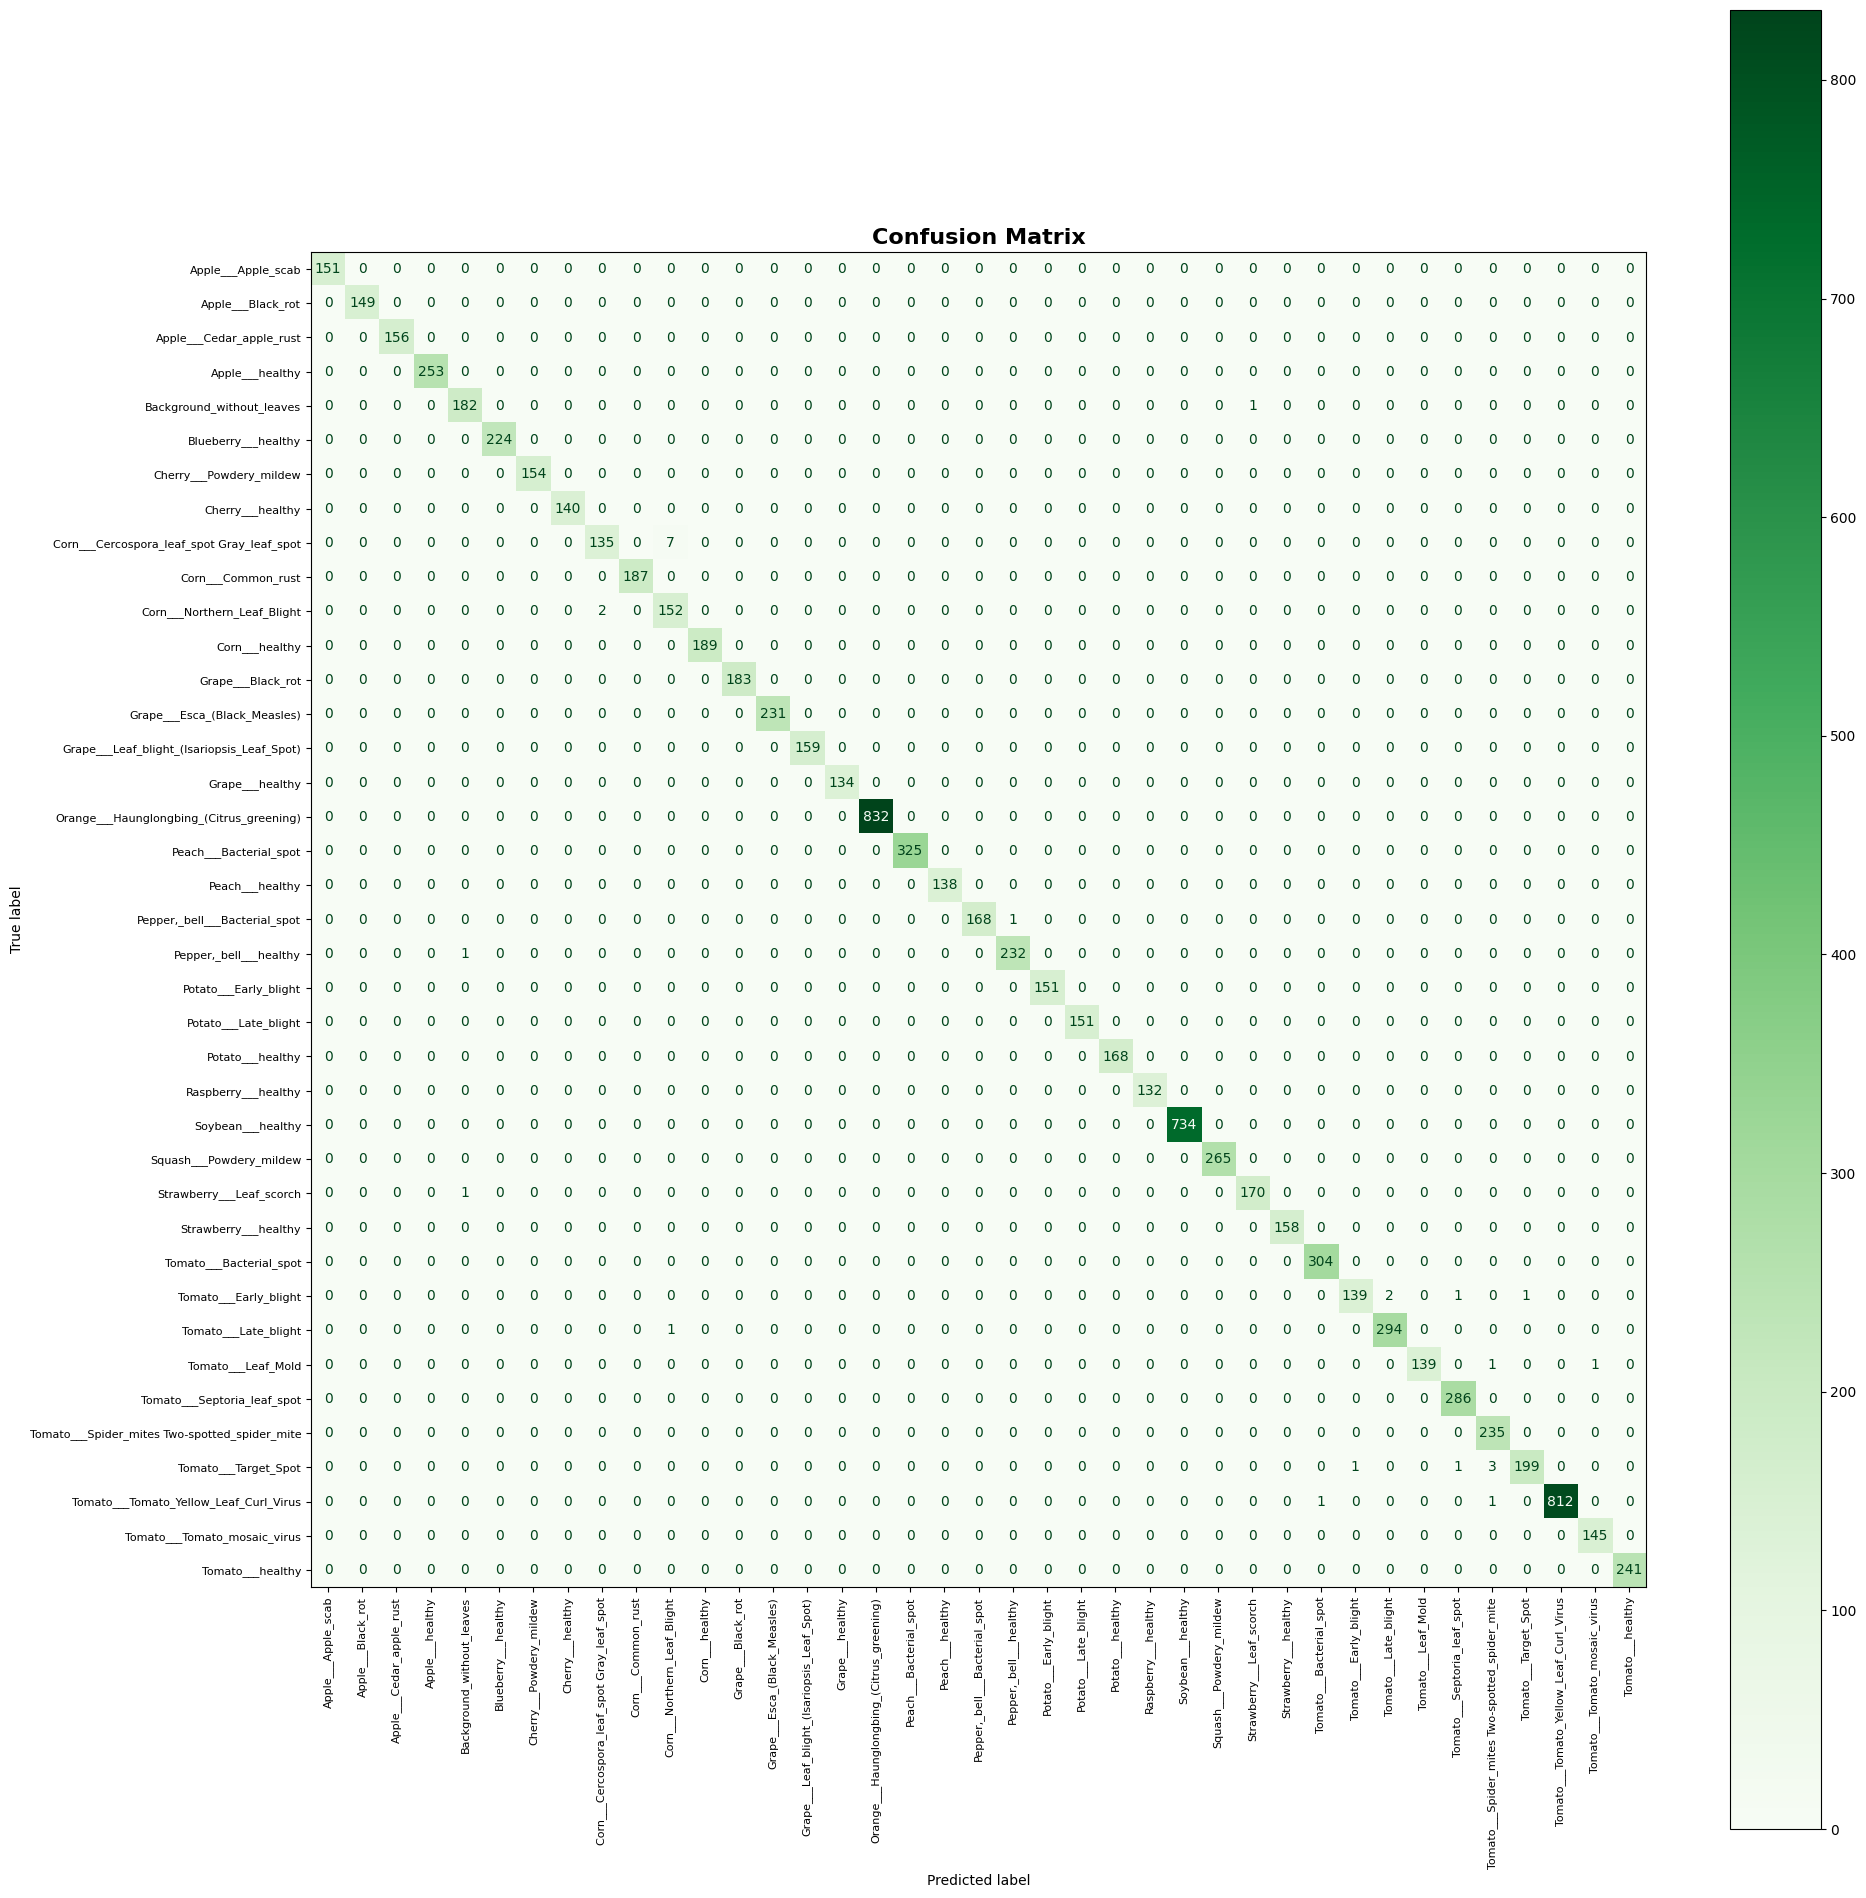

Confusion matrix saved to: outputs/plots/confusion_matrix.png
All artifacts stored under: outputs


In [ ]:
#!/usr/bin/env python3

import random
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import os

class LeafDiseaseClassifier:
    def __init__(self, args):
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.set_seed(args.seed)
        # Output dir
        self.output_dir = Path('outputs')
        self.output_dir.mkdir(exist_ok=True)
        (self.output_dir / 'models').mkdir(exist_ok=True)
        (self.output_dir / 'plots').mkdir(exist_ok=True)

    def set_seed(self, seed=42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def prepare_data(self):
        print("Loading pre-split dataset ...")
        base_tf = transforms.Compose([
            transforms.Resize((self.args.img_size, self.args.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        root = Path(self.args.data_dir)
        self.train_set = datasets.ImageFolder(root / 'augmented_train_pairs', transform=base_tf)
        self.val_set   = datasets.ImageFolder(root / 'val_pairs', transform=base_tf)
        self.test_set  = datasets.ImageFolder(root / 'test_pairs', transform=base_tf)

        # Keep a reference for class names & counts
        self.dataset = self.train_set
        print(f"Classes: {len(self.dataset.classes)}")
        print(f"Samples → Train: {len(self.train_set)} | Val: {len(self.val_set)} | Test: {len(self.test_set)}")

        self.train_loader = DataLoader(self.train_set, batch_size=self.args.batch_size, shuffle=True, num_workers=2)
        self.val_loader   = DataLoader(self.val_set, batch_size=self.args.batch_size, shuffle=False, num_workers=2)
        self.test_loader  = DataLoader(self.test_set, batch_size=self.args.batch_size, shuffle=False, num_workers=2)

    def build_model(self):
        print("Building ResNet-50 ...")
        # Load ImageNet pretrained weights
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_classes = len(self.dataset.classes)
        # Replace the last fully connected layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        if self.args.freeze_backbone:
            print("Freezing backbone parameters (training only the final FC).")
            for name, param in self.model.named_parameters():
                if not name.startswith('fc'):
                    param.requires_grad = False
        else:
            print("Training the entire network.")

        self.model = self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.args.lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)
        print(f"Model ready. Num classes = {num_classes}")

    def train(self):
        print("Start training ...")
        best_val_acc = 0.0
        patience_counter = 0
        # For plotting
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        for epoch in range(self.args.epochs):
            # Train
            self.model.train()
            running_loss, correct, total = 0, 0, 0

            for imgs, lbls in tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.args.epochs} Train'):
                imgs, lbls = imgs.to(self.device), lbls.to(self.device)
                self.optimizer.zero_grad()
                out = self.model(imgs)
                loss = self.criterion(out, lbls)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * imgs.size(0)
                pred = out.argmax(1)
                correct += (pred == lbls).sum().item()
                total += lbls.size(0)

            train_loss = running_loss / total
            train_acc = correct / total
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            # Validation
            self.model.eval()
            val_loss, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for imgs, lbls in self.val_loader:
                    imgs, lbls = imgs.to(self.device), lbls.to(self.device)
                    out = self.model(imgs)
                    loss = self.criterion(out, lbls)
                    val_loss += loss.item() * imgs.size(0)
                    pred = out.argmax(1)
                    val_correct += (pred == lbls).sum().item()
                    val_total += lbls.size(0)

            val_loss = val_loss / val_total
            val_acc = val_correct / val_total
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            self.scheduler.step()

            print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")
            # Early stopping & checkpoint
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                model_info = {
                    'model_state_dict': self.model.state_dict(),
                    'class_names': self.dataset.classes,
                    'num_classes': len(self.dataset.classes),
                    'img_size': self.args.img_size,
                    'model_architecture': 'ResNet50',
                    'freeze_backbone': self.args.freeze_backbone,
                    'best_val_acc': best_val_acc,
                    'epoch': epoch + 1
                }
                torch.save(model_info, self.output_dir / 'models' / 'best_model_complete.pth')
                torch.save(self.model.state_dict(), self.output_dir / 'models' / 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= self.args.patience:
                    print("Early stopping triggered.")
                    break
        # Plot learning curves
        self.plot_curves(train_losses, val_losses, train_accs, val_accs)

    def plot_curves(self, train_losses, val_losses, train_accs, val_accs):
        # Draw and save training / validation curves
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training & Validation Loss')
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training & Validation Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.savefig(self.output_dir / 'plots' / 'training_validation_curves.png')
        plt.show()
        plt.close()
        print("Curves saved to: outputs/plots/training_validation_curves.png")

    def test(self):
        print("Testing on the held-out test set ...")
        # Load best weights
        self.model.load_state_dict(torch.load(self.output_dir / 'models' / 'best_model.pth', map_location=self.device))
        self.model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for imgs, lbls in self.test_loader:
                imgs, lbls = imgs.to(self.device), lbls.to(self.device)
                out = self.model(imgs)
                pred = out.argmax(1)
                y_true.extend(lbls.cpu().numpy())
                y_pred.extend(pred.cpu().numpy())
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        print(f"Test Acc: {acc:.4f} Precision: {prec:.4f} Recall: {rec:.4f} F1: {f1:.4f}")
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=self.dataset.classes)
        fig, ax = plt.subplots(figsize=(20, 20))
        disp.plot(ax=ax, cmap='Greens', xticks_rotation=90)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(self.output_dir / 'plots' / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print("Confusion matrix saved to: outputs/plots/confusion_matrix.png")

    def run(self):
        self.prepare_data()
        self.build_model()
        self.train()
        self.test()
        print(f"All artifacts stored under: {self.output_dir}")

class Args:
    def __init__(self):
        self.data_dir = 'preprocessed_dataset'
        self.epochs = 20
        self.batch_size = 32
        self.lr = 2e-4
        self.patience = 6
        self.img_size = 224
        self.seed = 9444
        self.freeze_backbone = False

if __name__ == '__main__':
    args = Args()
    classifier = LeafDiseaseClassifier(args)
    classifier.run()

#### 7. Grad-CAM for ResNet50

In [ ]:
# Grad-CAM for ResNet50
import os
import torch
import numpy as np
from PIL import Image
from collections import defaultdict
from torchvision import datasets, transforms, models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Manual parameters
WEIGHT_PATH = "outputs/models/best_model.pth"
DATA_DIR = "preprocessed_dataset/test_pairs"
IMG_SIZE    = 224
BATCH_SIZE  = 1
NUM_SAMPLES = 15
OUT_DIR     = "gradcam_results"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Check dataset path
if not os.path.exists(DATA_DIR):
    print(f"Dataset path does not exist: {DATA_DIR}")
    print("Please verify the path.")
    exit(1)

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
print(f"Dataset loaded! Number of classes: {len(dataset.classes)}")

# Build a ResNet-50 identical to the training stage
num_classes = len(dataset.classes)
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Check weight file
if not os.path.exists(WEIGHT_PATH):
    print(f"Weight file not found: {WEIGHT_PATH}")
    exit(1)

try:
    model.load_state_dict(torch.load(WEIGHT_PATH, map_location=device))
    print("Model weights loaded!")
except Exception as e:
    print(f"Failed to load weights: {e}")
    exit(1)

model = model.to(device).eval()

# Use the last convolution of the final bottleneck block
target_layer = model.layer4[-1].conv3

def denormalize(t, m=[0.485, 0.456, 0.406], s=[0.229, 0.224, 0.225]):
    # Undo normalization for visualization
    t = t.clone().cpu()
    for ch, mean, std in zip(t, m, s):
        ch.mul_(std).add_(mean)
    return torch.clamp(t, 0, 1)

def generate_gradcam(model, dataset, target_layer, num_samples=5, output_dir="gradcam_results"):
    os.makedirs(output_dir, exist_ok=True)
    cam = GradCAM(model=model, target_layers=[target_layer])

    per_class = defaultdict(list)
    for img, lbl in dataset:
        if len(per_class[lbl]) < num_samples:
            per_class[lbl].append((img, lbl))

    print(f"Generating Grad-CAMs: {num_samples} samples per class...")
    
    for cls_idx, samples in per_class.items():
        cls_name = dataset.classes[cls_idx]
        cls_dir  = os.path.join(output_dir, cls_name)
        os.makedirs(cls_dir, exist_ok=True)
        print(f"Processing class: {cls_name}")

        for i, (img_t, lbl) in enumerate(samples):
            try:
                img_in = img_t.unsqueeze(0).to(device)
                grayscale_cam = cam(input_tensor=img_in, targets=[ClassifierOutputTarget(lbl)])[0]

                rgb_img = denormalize(img_t).permute(1, 2, 0).numpy()
                vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.5)

                Image.fromarray((rgb_img * 255).astype(np.uint8)).save(f"{cls_dir}/orig_{i}.jpg")
                Image.fromarray(vis).save(f"{cls_dir}/gradcam_{i}.jpg")
                
                print(f"  - Saved image {i+1}/{len(samples)}")
                
            except Exception as e:
                print(f"  - Error on image {i+1}: {e}")
                continue

    del cam
    torch.cuda.empty_cache()
    print(f"Grad-CAM results saved to: {output_dir}")

print("Starting Grad-CAM generation ...")
generate_gradcam(model, dataset, target_layer, num_samples=NUM_SAMPLES, output_dir=OUT_DIR)

Running on device: cuda
Dataset loaded! Number of classes: 39


C:\Users\CloudStar\AppData\Local\Temp\ipykernel_12960\2750146973.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(WEIGHT_PATH, map_locat

Model weights loaded!
Starting Grad-CAM generation ...
Generating Grad-CAMs: 15 samples per class...
Processing class: Apple___Apple_scab
  - Saved image 1/15
  - Saved image 2/15
  - Saved image 3/15
  - Saved image 4/15
  - Saved image 5/15
  - Saved image 6/15
  - Saved image 7/15
  - Saved image 8/15
  - Saved image 9/15
  - Saved image 10/15
  - Saved image 11/15
  - Saved image 12/15
  - Saved image 13/15
  - Saved image 14/15
  - Saved image 15/15
Processing class: Apple___Black_rot
  - Saved image 1/15
  - Saved image 2/15
  - Saved image 3/15
  - Saved image 4/15
  - Saved image 5/15
  - Saved image 6/15
  - Saved image 7/15
  - Saved image 8/15
  - Saved image 9/15
  - Saved image 10/15
  - Saved image 11/15
  - Saved image 12/15
  - Saved image 13/15
  - Saved image 14/15
  - Saved image 15/15
Processing class: Apple___Cedar_apple_rust
  - Saved image 1/15
  - Saved image 2/15
  - Saved image 3/15
  - Saved image 4/15
  - Saved image 5/15
  - Saved image 6/15
  - Saved image

#### 8. Display one pair of Original and Grad-CAM images for each class folder.
- Each row shows: [Original] [Grad-CAM]
- The class name is shown above both images.


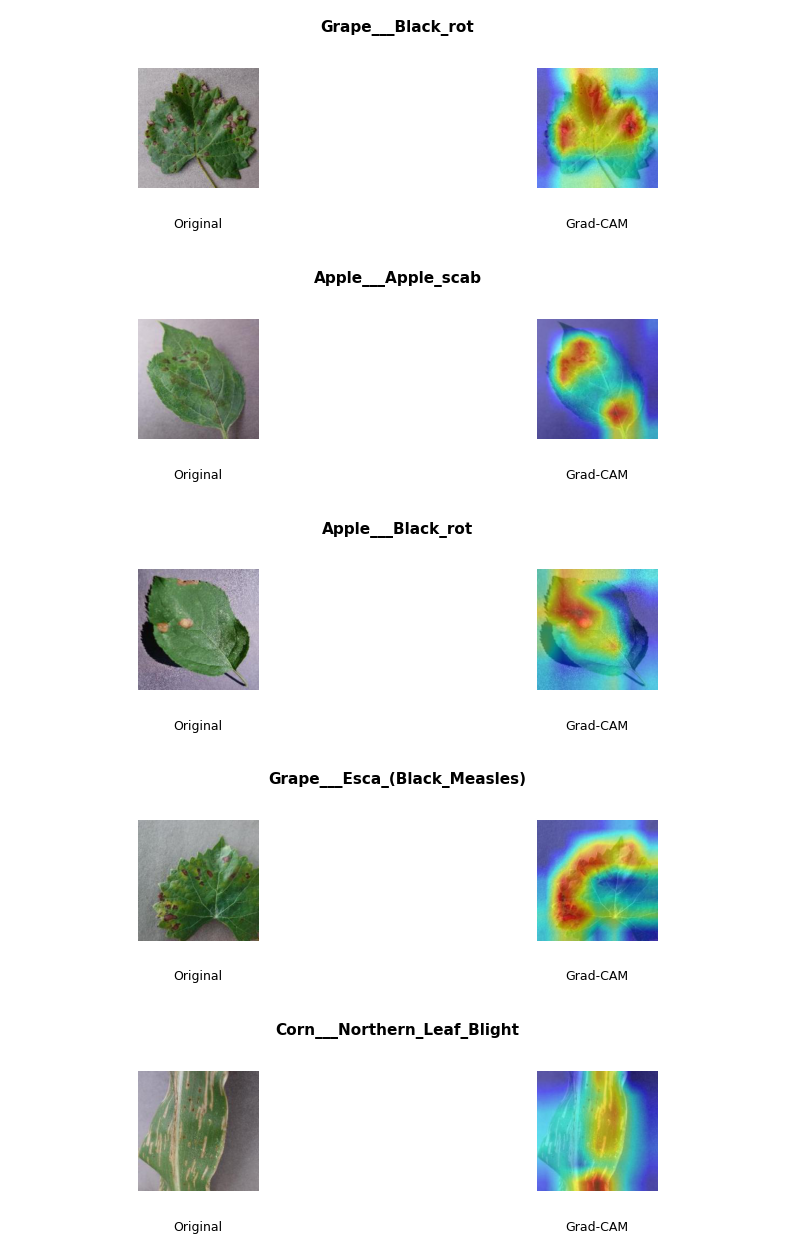

In [ ]:
import matplotlib.pyplot as plt
import glob
import os
import random
from PIL import Image

def show_gradcam_by_class(result_dir="gradcam_results", num_classes=5, seed=None):

    if seed is not None:
        random.seed(seed)

    # Collect all class folders
    class_dirs = [d for d in glob.glob(os.path.join(result_dir, "*")) if os.path.isdir(d)]
    if not class_dirs:
        print("No class folders found.")
        return

    # Randomly pick num_classes folders
    class_dirs = random.sample(class_dirs, min(num_classes, len(class_dirs)))

    # Build pairs
    pairs = []
    for cls_dir in class_dirs:
        cls_name = os.path.basename(cls_dir)
        orig_files = glob.glob(os.path.join(cls_dir, "original_*.jpg"))
        grad_files = glob.glob(os.path.join(cls_dir, "gradcam_*.jpg"))
        if not orig_files or not grad_files:
            continue

        orig_map = {os.path.basename(p)[len("original_"):]: p for p in orig_files}
        grad_map = {os.path.basename(p)[len("gradcam_"):]: p for p in grad_files}
        common = sorted(set(orig_map) & set(grad_map))
        if not common:
            continue

        key = random.choice(common)
        pairs.append((cls_name, orig_map[key], grad_map[key]))

    if not pairs:
        print("No matched original_* and gradcam_* image pairs found.")
        return

    nrows = len(pairs)

    # Figure & GridSpec
    fig = plt.figure(figsize=(10, 3.2 * nrows))
    hr = []
    for _ in range(nrows):
        hr.extend([0.30, 1.00, 0.24])  
    gs = fig.add_gridspec(3 * nrows, 2, height_ratios=hr, hspace=0.35, wspace=0.06)

    for i, (cls_name, orig_path, grad_path) in enumerate(pairs):
        base = 3 * i

        # Title
        ax_title = fig.add_subplot(gs[base, :])
        ax_title.axis("off")
        ax_title.text(0.5, 0.5, cls_name, ha="center", va="center",
                      fontsize=11, fontweight="bold")

        # Images
        ax_left  = fig.add_subplot(gs[base + 1, 0])
        ax_right = fig.add_subplot(gs[base + 1, 1])

        orig_img = Image.open(orig_path).convert("RGB")
        grad_img = Image.open(grad_path).convert("RGB")

        ax_left.imshow(orig_img);  ax_left.axis("off")
        ax_right.imshow(grad_img); ax_right.axis("off")

        # Labels
        ax_labl = fig.add_subplot(gs[base + 2, 0])
        ax_labr = fig.add_subplot(gs[base + 2, 1])
        for ax, text in ((ax_labl, "Original"), (ax_labr, "Grad-CAM")):
            ax.axis("off")
            ax.text(0.5, 0.5, text, ha="center", va="center", fontsize=9)

    plt.show()

show_gradcam_by_class("gradcam_results")